# PyTorch


### Task Explanation

In this part we will implement, train and evaluate a neural network using pyTorch on wheat disease classification problem. 

Wheat rust is a devastating plant disease that affects many crops, reducing yields and affecting the livelihoods of farmers and decreasing food security across the continent. The disease is difficult to monitor at a large scale, making it difficult to control and eradicate.

The objective of this challenge is to build a machine learning algorithm to correctly classify if a plant is healthy, has stem rust, or has leaf rust.

### Let's Start

Make necessary imports here e.g. import cv2, import glob, etc

In [ ]:

# any other imports that you may require
import matplotlib.pyplot as plt
import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
import glob
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, accuracy_score

The following code decides whether to run on GPU or CPU. You can have a look [here](https://pytorch.org/docs/stable/notes/cuda.html) to understand how to use this here in this task.

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Hyperparameters

You can play with these to improve accuracy on test data.

In [ ]:
batch_size = 15 
epochs = 20 
learning_rate = 0.0001
input_shape = (3,256,256) #80


### Data

Get Wheat Disease Data for training and testing

In [1]:
!git clone https://github.com/MMFa666/WheatDiseaseDataset.git

Cloning into 'WheatDiseaseDataset'...
remote: Enumerating objects: 749, done.
remote: Total 749 (delta 0), reused 0 (delta 0), pack-reused 749
Receiving objects: 100% (749/749), 386.05 MiB | 38.35 MiB/s, done.
Checking out files: 100% (877/877), done.


Get paths for all the training images in the dataset and print the length of training_paths list. For this purpose you can use glob. You can have a look [here](https://www.geeksforgeeks.org/how-to-use-glob-function-to-find-files-recursively-in-python/) on how to use glob.

In [2]:
# code here
import glob
training_paths = glob.glob('WheatDiseaseDataset/train/*/*.jpg')
print('Length of training_paths:', len(training_paths))


Length of training_paths: 699


Do the same for testing data images.

In [3]:
# code here
testing_paths = glob.glob('WheatDiseaseDataset/test/*/*.jpg')
print('Length of testing data images:', len(testing_paths))


Length of testing data images: 177


### Labels

In [ ]:
my_labels={}
my_labels['healthy_wheat'] = 0
my_labels['leaf_rust'] = 1
my_labels['stem_rust'] = 2

### Preprocessing

Preprocessing of data such as normalization, mean shift, make the learning task simple for network and could accelerate the training process. In this task, we will only do normaliztion.

In images, pixel values range from 0 to 255. To shift the values between (0,1) range, divide input image by 255.


In [ ]:
print(training_paths[0])

WheatDiseaseDataset/train/stem_rust/7QBIPY.jpg


In [ ]:
def preprocessing_norm(images):
    #pass
    normalized_images = images.astype('float32')/255
    return normalized_images

### Batch Generator

Previously, when training our models, we were loading the complete data in memory to fit our model. However, in practice we're working with very large datasets which cannot be loaded all at once in memory. As a solution, we use "Data Generators" which are essentially python generators that load batches of data from disk into memory and pass into our models. In order to achieve this, we only store filepaths that point to training/test samples in our dataset in memory. A data generator yields a tuple of (Xs,Ys) whenever the generator is used via the next() function. 

For examples of batch_generators, you can have a look [here](https://www.geeksforgeeks.org/generators-in-python/) or [here](https://www.programcreek.com/python/?CodeExample=generate+batches). Essentially you have to the following:
- Shuffle the paths to get a uniform distribution in all batches.
- Divide paths into batches.
- Read image from the path. (Remeber cv2 reads image in BGR format.)
- Resize each image to input_shape.
- Pytorch accepts channels-first input style. So transpose the images. (Hint: see np.transpose())
- Extract label of the image from the image path using folder name. (Hint: You can do this by splitting the path.)
- No need to one-hot encode here.
- Yield images and labels in tuple.



In [ ]:
# Batch generator function here.
def BatchGenerator(training_data, batch_size, shuffle):
  np.random.shuffle(training_data)
  while(1):
    for x in range(0, len(training_data), batch_size):
      train_img = training_data[x:x+batch_size]
      data = []
      labels = []
      for img in train_img:
        x = img
        img = cv2.imread(img)
        img = cv2.resize(img, (256,256))
        img = preprocessing_norm(img)
        data.append(np.transpose(img))
        y = x.split('/')[-2]
        labels.append(my_labels[y])
      yield np.array(data), np.array(labels)


Initialize train data generator using a [DataLoader](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#:~:text=return%20image%2C%20label-,Preparing%20your%20data%20for%20training%20with%20DataLoaders,-The%20Dataset%20retrieves)

In [ ]:
# code here
train_dataloader = BatchGenerator(training_paths, batch_size, shuffle=True)

### Task 1

### Training

Define network class here. You can have a look [here](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#define-a-convolutional-neural-network) to understand how this works.

Model architecture is provided in model1.png


- Stride = 2, Padding = 0 for all convolutional layers
- Dropout ratio is 0.2
- Kernel size = 5 for first Convolutional layer, 3 for rest of the layers.

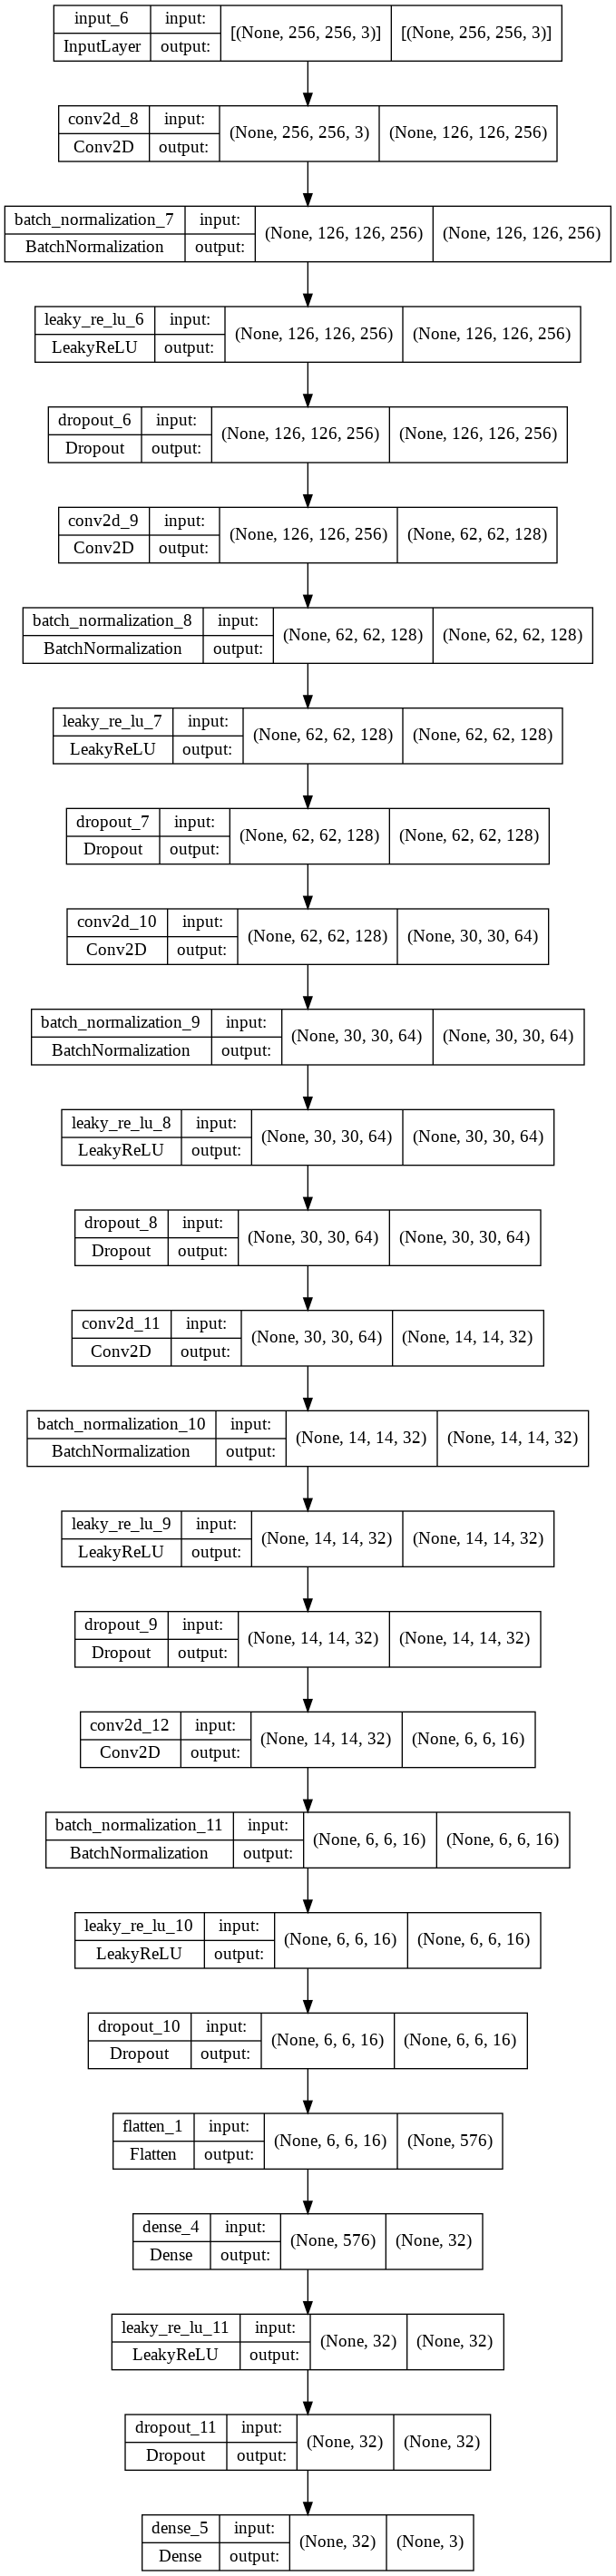

In [ ]:
# code here
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 256, 5, 2)
        self.batch1 = nn.BatchNorm2d(256)
        self.relu1 = nn.LeakyReLU()
        #self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.2)

        self.conv2 = nn.Conv2d(256, 128, 3, 2)
        self.batch2 = nn.BatchNorm2d(128)
        self.relu2 = nn.LeakyReLU()
        self.dropout2 = nn.Dropout(0.2)

        self.conv3 = nn.Conv2d(128, 64, 3, 2)
        self.batch3 = nn.BatchNorm2d(64)
        self.relu3 = nn.LeakyReLU()
        self.dropout3 = nn.Dropout(0.2)

        self.conv4 = nn.Conv2d(64, 32, 3, 2)
        self.batch4 = nn.BatchNorm2d(32)
        self.relu4 = nn.LeakyReLU()
        self.dropout4 = nn.Dropout(0.2)

        self.conv5 = nn.Conv2d(32, 16, 3, 2)
        self.batch5 = nn.BatchNorm2d(16)
        self.relu5 = nn.LeakyReLU()
        self.dropout5 = nn.Dropout(0.2)

        self.flatten = nn.Flatten()
        self.dense1 = nn.Linear(576, 32)
        self.relu6 = nn.LeakyReLU()
        self.dropout6 = nn.Dropout(0.2)
        self.dense2 = nn.Linear(32, 3)

    
    def forward(self, x):
      x = self.dropout1(self.relu1(self.batch1(self.conv1(x))))

      x = self.dropout2(self.relu2(self.batch2(self.conv2(x))))
      
      x = self.dropout3(self.relu3(self.batch3(self.conv3(x))))
      
      x = self.dropout4(self.relu4(self.batch4(self.conv4(x))))

      x = self.dropout5(self.relu5(self.batch5(self.conv5(x))))

      #print(x.shape)
      x = self.dropout6(self.relu6(self.dense1(self.flatten(x))))
      #print(x.shape) 
      x = self.dense2(x)

      return x


Initialize network and cast it to device declared above. (Hint: net.to(device) )

In [ ]:
# code here
net = Net()
net =net.to(device)


In [ ]:
#print model summary here
summary(net, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [-1, 256, 126, 126]          19,456
       BatchNorm2d-2        [-1, 256, 126, 126]             512
         LeakyReLU-3        [-1, 256, 126, 126]               0
           Dropout-4        [-1, 256, 126, 126]               0
            Conv2d-5          [-1, 128, 62, 62]         295,040
       BatchNorm2d-6          [-1, 128, 62, 62]             256
         LeakyReLU-7          [-1, 128, 62, 62]               0
           Dropout-8          [-1, 128, 62, 62]               0
            Conv2d-9           [-1, 64, 30, 30]          73,792
      BatchNorm2d-10           [-1, 64, 30, 30]             128
        LeakyReLU-11           [-1, 64, 30, 30]               0
          Dropout-12           [-1, 64, 30, 30]               0
           Conv2d-13           [-1, 32, 14, 14]          18,464
      BatchNorm2d-14           [-1, 32,

Define [CrossEntropy Loss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) and [RMSprop](https://pytorch.org/docs/stable/optim.html#:~:text=Implements%20RAdam%20algorithm.-,RMSprop,-Implements%20RMSprop%20algorithm) optimizer here. (Hint: See the links to understand how to do this.)

In [ ]:
# Code here
loss_fn = nn.CrossEntropyLoss()
loss_fn = loss_fn.to(device)
optimizer = optim.RMSprop(net.parameters(), lr=learning_rate, momentum=0.9)

In [ ]:
# Intialize num_training_batches.
num_training_batches=len(training_paths)//batch_size

Train the network here. You can have look [here](https://pytorch.org/tutorials/beginner/introyt/trainingyt.html#:~:text=0.001%2C%20momentum%3D0.9) to understand how to do this. Remember to convert your data and labels to pytorch tensors and cast to device before passing it to the network. Also, record the training loss for plotting purposes.

In [ ]:
def train_one_epoch(epoch):
    running_loss = 0.
    for i, data in enumerate(train_dataloader,0):
      inputs, labels = data
      optimizer.zero_grad()

      inputs = torch.from_numpy(inputs).float()
      inputs = inputs.to(device)
      outputs = net(inputs)

      labels = torch.from_numpy(labels)
      labels = labels.to(device)
  
      loss = loss_fn(outputs, labels)
      loss.backward()
      optimizer.step()

      running_loss += loss.item()
      if i % (num_training_batches +1) == num_training_batches:
            last_loss = running_loss / (num_training_batches+1)
            print('{} loss: {}'.format(epoch + 1, last_loss))
            return last_loss

In [ ]:
a = 0
training_loss = []
for epoch in range(epochs):
  avg_loss = train_one_epoch(epoch)
  training_loss.append(avg_loss)

1 loss: 0.9781609088816541
2 loss: 0.8385803154174317
3 loss: 0.7416706478342097
4 loss: 0.6934947961188377
5 loss: 0.628059743566716
6 loss: 0.587188149386264
7 loss: 0.5292435358179376
8 loss: 0.47070270047542895
9 loss: 0.4155219355796246
10 loss: 0.33768849043135946
11 loss: 0.2971908878138725
12 loss: 0.2540715974062047
13 loss: 0.22228274526114158
14 loss: 0.23765413264961952
15 loss: 0.19753983573235095
16 loss: 0.1445885114768084
17 loss: 0.21994325463125047
18 loss: 0.1718439588402497
19 loss: 0.11970926181195264
20 loss: 0.09204491708388036


Plot the loss graph of training.

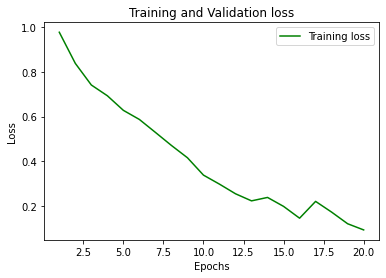

In [ ]:
# Loss Plot
epochs = range(1,21)
plt.plot(epochs, training_loss, 'g', label='Training loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Evaluation

Now, we will evaluate our model on the test data.

First, let's read the test data using test_paths. Similar to what we did in batch_generator.

In [ ]:
# code here
test_x = []
test_labels = []
for x in range(0, len(testing_paths)):
  a = testing_paths[x]
  img = cv2.imread(testing_paths[x])
  img = cv2.resize(img, (256,256))
  img = preprocessing_norm(img)
  test_x.append(np.transpose(img))
  y = a.split('/')[-2]
  test_labels.append(my_labels[y])


Put the network in eval mode using your_model.eval()

In [ ]:
# code here
net.eval()

Net(
  (conv1): Conv2d(3, 256, kernel_size=(5, 5), stride=(2, 2))
  (batch1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): LeakyReLU(negative_slope=0.01)
  (dropout1): Dropout(p=0.2, inplace=False)
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(2, 2))
  (batch2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): LeakyReLU(negative_slope=0.01)
  (dropout2): Dropout(p=0.2, inplace=False)
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(2, 2))
  (batch3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): LeakyReLU(negative_slope=0.01)
  (dropout3): Dropout(p=0.2, inplace=False)
  (conv4): Conv2d(64, 32, kernel_size=(3, 3), stride=(2, 2))
  (batch4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu4): LeakyReLU(negative_slope=0.01)
  (dropout4): Dropout(p=0.2, inplace=False)
  (conv5): Conv2d(32, 16, kernel_s

Now, make predictions on test data. Cast the outputs to cpu and convert to numpy (using outputs.cpu().numpy()). If you get memory error then you can loop over all images one by one and then make and store the prediction.

In [ ]:
# code here
test_x = torch.from_numpy(np.array(test_x))
test_x = test_x.to(device)
preds = net(test_x).cpu().detach().numpy()


Extract class label from predictions. (Hint: you can use np.argmax() ).

In [ ]:
# code here
class_labels = np.argmax(preds, axis=1)
#print(class_labels)

Calculate and print accuracy.

In [ ]:
# code here
accuracy = accuracy_score(test_labels, class_labels)
print('Accuracy for test data is:', accuracy)

Accuracy for test data is: 0.8022598870056498


Calculate and print Confusion Matrix. Have a look [here](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) for this.

In [ ]:
# code here
con_m = confusion_matrix(test_labels, class_labels)


In [ ]:
def plot_confusion_matrix(conf_mat):
    classes = list(my_labels.keys())
    df_cm = pd.DataFrame(conf_mat,classes,classes)
    plt.figure(figsize=(10,7))
    sns.set(font_scale=1.4)
    sns.heatmap(df_cm, annot=True,annot_kws={"size": 16})
    plt.show()

Use the above function to plot confusion matrix here.

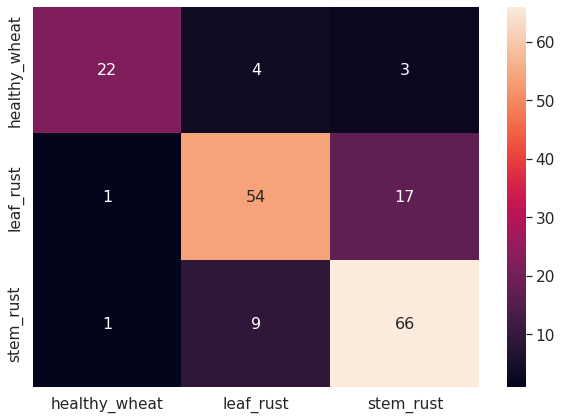

In [ ]:
# code here
plot_confusion_matrix(con_m)


### Task 2




In [ ]:
batch_size = 14
epochs = 20
learning_rate = 0.0001
input_shape = (3,256,256)

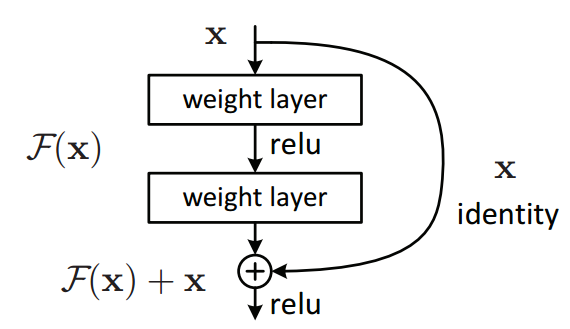

Now we'll add a skip connection to the convolutional network we have prepared .

These skip connections are the foundation for ResNet models which have produced state of the art results on datasets.

A sample architecture is provided in model2.png

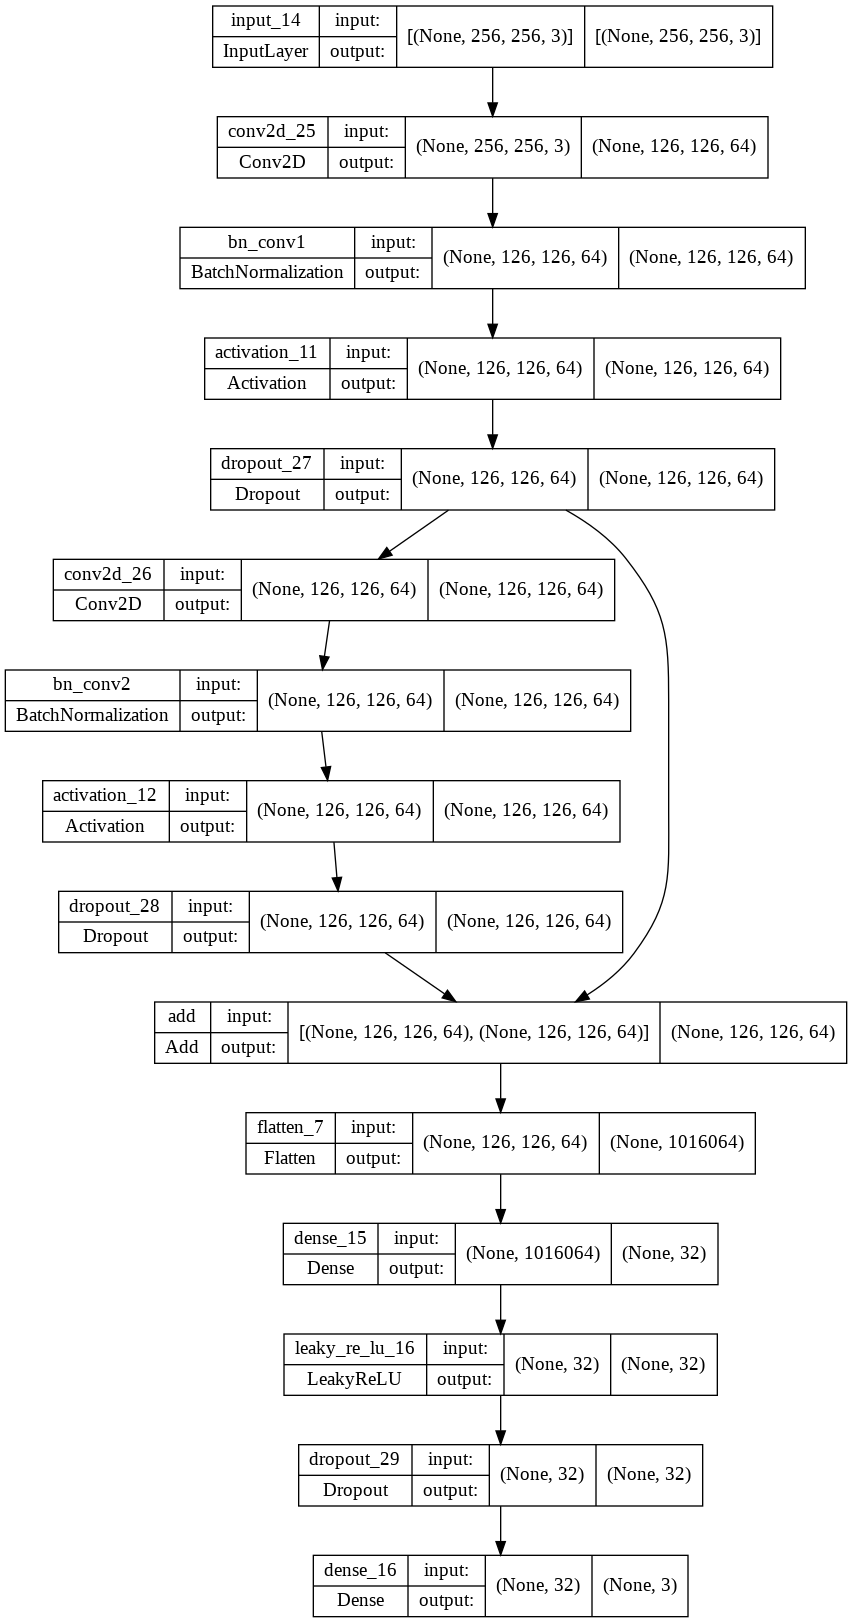

Define Network class

In [ ]:
# Code here
class Net2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, 5, 2)
        self.batch1 = nn.BatchNorm2d(64)
        self.act1 = nn.Softmax(dim=1)
        self.dropout1 = nn.Dropout(0.2)
        
        self.conv2 = nn.Conv2d(64, 64, 1, 1)
        self.batch2 = nn.BatchNorm2d(64)
        self.act2 = nn.Softmax(dim=1)
        self.dropout2 = nn.Dropout(0.2)

        self.flatten = nn.Flatten()
        self.dense1 = nn.Linear(1016064, 32)
        self.relu1 = nn.LeakyReLU()
        self.dropout3 = nn.Dropout(0.2)
        self.dense2 = nn.Linear(32, 3)

    
    def forward(self, x):
      
      x1 = self.dropout1(self.act1(self.batch1(self.conv1(x))))
      x2 = self.conv2(x1)
      x2 = self.dropout2(self.act2(self.batch2(x2)))
      x = self.dropout3(self.relu1(self.dense1(self.flatten(x2+x1))))
      x = self.dense2(x)

      return x


Initialize model and cast it to device

In [ ]:
# Code here
t2_net = Net2()
t2_net =t2_net.to(device)

Print Summary

In [ ]:
# Code here
summary(t2_net, input_shape)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 126, 126]           4,864
       BatchNorm2d-2         [-1, 64, 126, 126]             128
           Softmax-3         [-1, 64, 126, 126]               0
           Dropout-4         [-1, 64, 126, 126]               0
            Conv2d-5         [-1, 64, 126, 126]           4,160
       BatchNorm2d-6         [-1, 64, 126, 126]             128
           Softmax-7         [-1, 64, 126, 126]               0
           Dropout-8         [-1, 64, 126, 126]               0
           Flatten-9              [-1, 1016064]               0
           Linear-10                   [-1, 32]      32,514,080
        LeakyReLU-11                   [-1, 32]               0
          Dropout-12                   [-1, 32]               0
           Linear-13                    [-1, 3]              99
Total params: 32,523,459
Trainable para

Define loss, optimizer and train the new model 

In [ ]:
# Code here
loss_fn2 = nn.CrossEntropyLoss()
loss_fn2 = loss_fn2.to(device)
optimizer2 = optim.RMSprop(t2_net.parameters(), lr=learning_rate, momentum=0.9)

In [ ]:
def train_one_epoch(epoch):
    running_loss = 0.
    for i, data in enumerate(train_dataloader,0):
      inputs, labels = data
      optimizer2.zero_grad()

      inputs = torch.from_numpy(inputs).float()
      inputs = inputs.to(device)
      outputs = t2_net(inputs)

      labels = torch.from_numpy(labels)
      labels = labels.to(device)
  
      loss = loss_fn2(outputs, labels)
      loss.backward()
      optimizer2.step()

      running_loss += loss.item()
      if i % (num_training_batches +1) == num_training_batches:
            last_loss = running_loss / (num_training_batches+1)
            print('{} loss: {}'.format(epoch + 1, last_loss))
            return last_loss

a = 0
training_loss = []
for epoch in range(epochs):
  avg_loss = train_one_epoch(epoch)
  training_loss.append(avg_loss)


1 loss: 5.895362070798874
2 loss: 0.9679765319824218
3 loss: 0.8498439967632294
4 loss: 0.8203722429275513
5 loss: 0.7689334028959274
6 loss: 0.6474633368849755
7 loss: 0.6384115505218506
8 loss: 0.5352781468629837
9 loss: 0.5007224097847939
10 loss: 0.5179229861497879
11 loss: 0.38320683628320695
12 loss: 0.4663316833972931
13 loss: 0.4500817044079304
14 loss: 0.42756022829562423
15 loss: 0.3055686764419079
16 loss: 0.24124524362385272
17 loss: 0.25446228289976713
18 loss: 0.26987972102942875
19 loss: 0.3776175921596587
20 loss: 0.3055357816070318


Make preditions, extract labels, calculate accuracy and plot confusion matrix as done in Task 1.

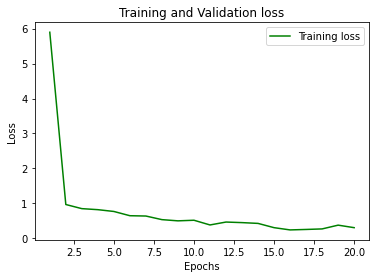

In [ ]:
# Code here
# Loss Plot
epochs = range(1,21)
plt.plot(epochs, training_loss, 'g', label='Training loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
# code here
test_x = []
test_labels = []
for x in range(0, len(testing_paths)):
  a = testing_paths[x]
  img = cv2.imread(testing_paths[x])
  img = cv2.resize(img, (256,256))
  img = preprocessing_norm(img)
  test_x.append(np.transpose(img))
  y = a.split('/')[-2]
  test_labels.append(my_labels[y])

# code here
t2_net.eval()
test_x = torch.from_numpy(np.array(test_x))
test_x = test_x.to(device)
preds = t2_net(test_x).cpu().detach().numpy()

class_labels = np.argmax(preds, axis=1)

Accuracy for test data is: 0.7401129943502824


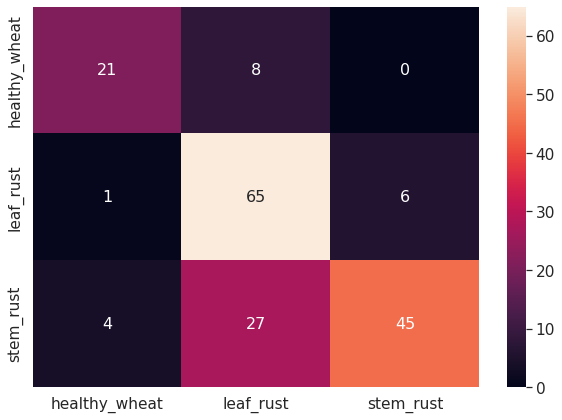

In [ ]:
# code here
accuracy = accuracy_score(test_labels, class_labels)
print('Accuracy for test data is:', accuracy)
con_m = confusion_matrix(test_labels, class_labels)
plot_confusion_matrix(con_m)


### Task 3

In [ ]:
batch_size = 7
epochs = 15
learning_rate = 0.0001
input_shape = (3,256,256)
#task 3

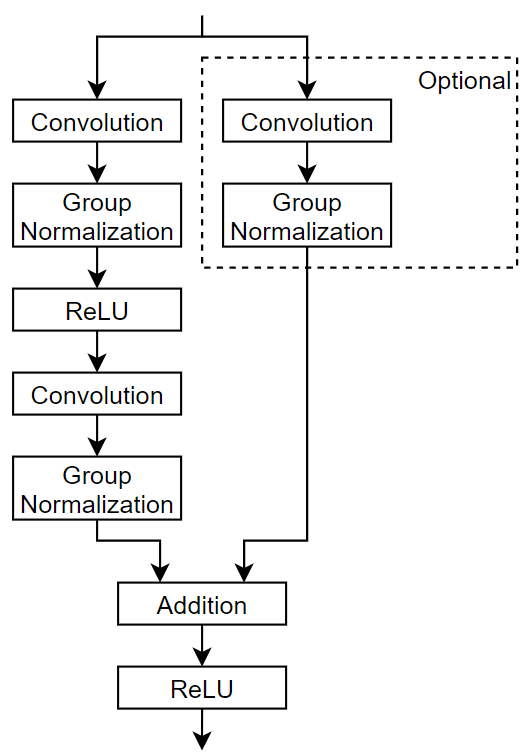

Next we will learn about a different scenario in the skip connection.


Previously, we simply added the input to the output of the convolutional layer's output. 
However, the size of the output might be modified when passed through convolutional layers so the input connection to be added to the output also has to be passed through a convolutional layer to match the output sizes.


In this model, we will modify the identity connection to match output shape.

see model3.png for the architecture.

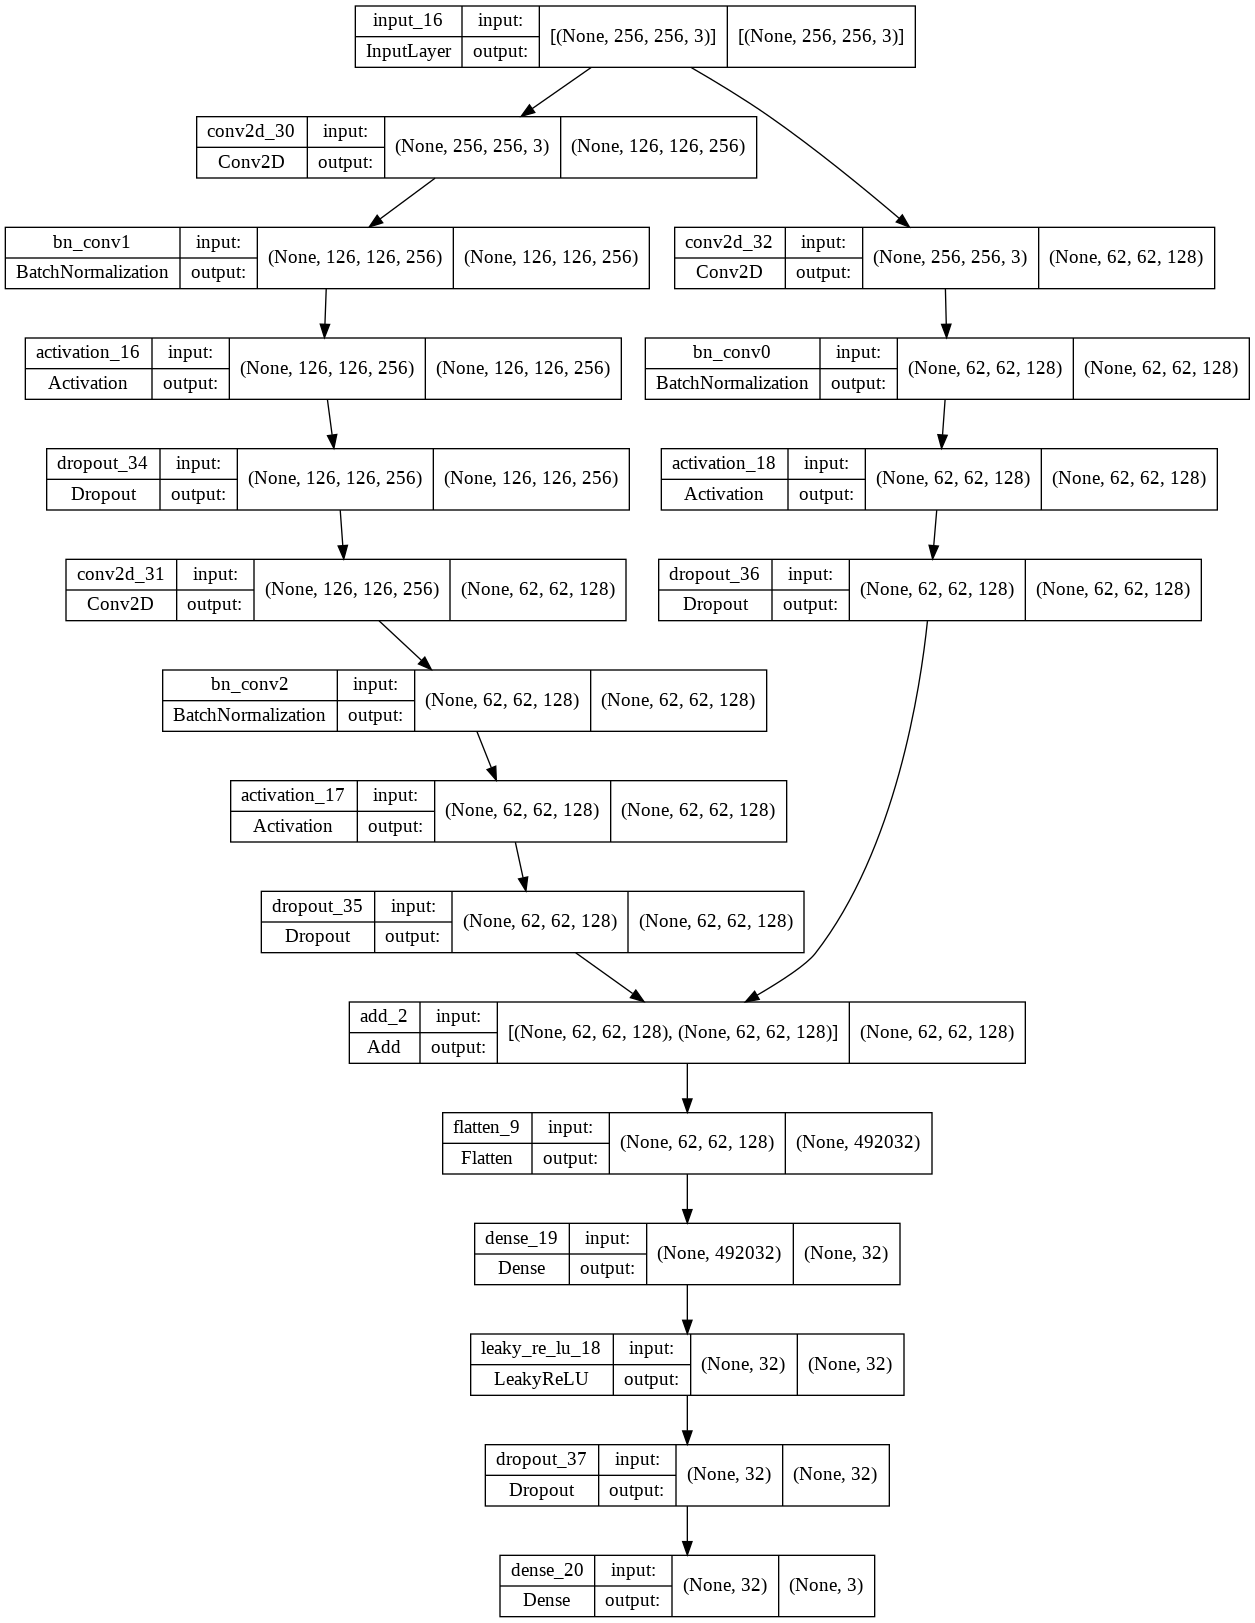

Define Network class

In [ ]:
# Code here
class Net3(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 256, 5, 2)
        self.batch1 = nn.BatchNorm2d(256)
        #self.act1 = nn.LeakyReLU()
        self.act1 = nn.Softmax(dim=1)
        self.dropout1 = nn.Dropout(0.2)
        
        self.conv2 = nn.Conv2d(256, 128, 3, 2)
        self.batch2 = nn.BatchNorm2d(128)
        self.act2 = nn.Softmax(dim=1)
        self.dropout2 = nn.Dropout(0.2)

        self.conv3 = nn.Conv2d(3, 128, 12, 4)
        self.batch3 = nn.BatchNorm2d(128)
        self.act3 = nn.Softmax(dim=1)
        self.dropout3 = nn.Dropout(0.2)

        self.flatten = nn.Flatten()
        self.dense1 = nn.Linear(492032, 32)
        self.relu3 = nn.LeakyReLU()
        self.dropout6 = nn.Dropout(0.2)
        self.dense2 = nn.Linear(32, 3)

    
    def forward(self, x):
      x1 = self.dropout1(self.act1(self.batch1(self.conv1(x))))
      x1 = self.conv2(x1)
      x1 = self.dropout2(self.act2(self.batch2(x1)))
      x2 = self.dropout3(self.act3(self.batch3(self.conv3(x))))
      x = self.dropout3(self.relu3(self.dense1(self.flatten(x2+x1))))
      x = self.dense2(x)

      return x



Initialize model and cast it to device.

In [ ]:

# Code here
t3_net = Net3()
t3_net =t3_net.to(device)

Print Summary

In [ ]:
# Code here
summary(t3_net, input_shape)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [-1, 256, 126, 126]          19,456
       BatchNorm2d-2        [-1, 256, 126, 126]             512
           Softmax-3        [-1, 256, 126, 126]               0
           Dropout-4        [-1, 256, 126, 126]               0
            Conv2d-5          [-1, 128, 62, 62]         295,040
       BatchNorm2d-6          [-1, 128, 62, 62]             256
           Softmax-7          [-1, 128, 62, 62]               0
           Dropout-8          [-1, 128, 62, 62]               0
            Conv2d-9          [-1, 128, 62, 62]          55,424
      BatchNorm2d-10          [-1, 128, 62, 62]             256
          Softmax-11          [-1, 128, 62, 62]               0
          Dropout-12          [-1, 128, 62, 62]               0
          Flatten-13               [-1, 492032]               0
           Linear-14                   

Define loss, optimizer and train model.

In [ ]:
# Code here
loss_fn3 = nn.CrossEntropyLoss()
loss_fn3 = loss_fn3.to(device)
optimizer3 = optim.RMSprop(t3_net.parameters(), lr=learning_rate, momentum=0.9)

In [ ]:
# Intialize num_training_batches.
num_training_batches=len(training_paths)//batch_size

In [ ]:
def train_one_epoch(epoch):
    running_loss = 0.
    for i, data in enumerate(train_dataloader,0):
      inputs, labels = data
      optimizer3.zero_grad()

      inputs = torch.from_numpy(inputs).float()
      inputs = inputs.to(device)
      outputs = t3_net(inputs)

      labels = torch.from_numpy(labels)
      labels = labels.to(device)
  
      loss = loss_fn3(outputs, labels)
      loss.backward()
      optimizer3.step()

      running_loss += loss.item()
      if i % (num_training_batches +1) == num_training_batches:
            last_loss = running_loss / (num_training_batches+1)
            print('{} loss: {}'.format(epoch + 1, last_loss))
            return last_loss


training_loss = []
for epoch in range(epochs):
  avg_loss = train_one_epoch(epoch)
  training_loss.append(avg_loss)


1 loss: 1.2966899424791336
2 loss: 0.9429056394100189
3 loss: 0.9033157441020012
4 loss: 0.8545526140928268
5 loss: 0.8893294140696526
6 loss: 0.7053346472978592
7 loss: 0.6442530409991741
8 loss: 0.45448736049234867
9 loss: 0.31175137558951976
10 loss: 0.26965402541682126
11 loss: 0.1529166477266699
12 loss: 0.2212260738459736
13 loss: 0.1812340810917158
14 loss: 0.14468150563770904
15 loss: 0.10463358913812044


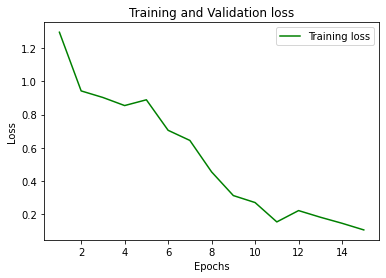

In [ ]:
# Code here
# Loss Plot
epochs = range(1,16) 
plt.plot(epochs, training_loss, 'g', label='Training loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()



In [ ]:
# Batch generator function here.
def test_BatchGenerator(data, batch_size, shuffle):
  for x in range(0, len(data), batch_size):
    train_img = data[x:x+batch_size]
    data_t = []
    labels = []
    for img in train_img:
      x = img
      img = cv2.imread(img)
      img = cv2.resize(img, (256,256))
      img = preprocessing_norm(img)
      data_t.append(np.transpose(img))
      y = x.split('/')[-2]
      #print(my_labels[y])
      labels.append(my_labels[y])
    yield np.array(data_t), np.array(labels)


In [ ]:
# code here
test_dataloader = test_BatchGenerator(testing_paths, 3, shuffle=True)

In [ ]:
t3_net.eval()

Net3(
  (conv1): Conv2d(3, 256, kernel_size=(5, 5), stride=(2, 2))
  (batch1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): Softmax(dim=1)
  (dropout1): Dropout(p=0.2, inplace=False)
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(2, 2))
  (batch2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act2): Softmax(dim=1)
  (dropout2): Dropout(p=0.2, inplace=False)
  (conv3): Conv2d(3, 128, kernel_size=(12, 12), stride=(4, 4))
  (batch3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act3): Softmax(dim=1)
  (dropout3): Dropout(p=0.2, inplace=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dense1): Linear(in_features=492032, out_features=32, bias=True)
  (relu3): LeakyReLU(negative_slope=0.01)
  (dropout6): Dropout(p=0.2, inplace=False)
  (dense2): Linear(in_features=32, out_features=3, bias=True)
)

In [ ]:
pred_list = []
true_list = []
for i, data in enumerate(test_dataloader,0):
  test_x, true_labels = data
  true_list.append(true_labels)
  test = torch.from_numpy(np.array(test_x))
  test = test.to(device)
  preds = t3_net(test).cpu().detach().numpy()
  class_labels = np.argmax(preds, axis=1)
  pred_list.append(class_labels)
  if i == len(testing_paths)/3 - 1:
    break


In [ ]:
true_label = []
[[true_label.append(x) for x in i] for i in pred_list]
class_label = []
[[class_label.append(x) for x in i] for i in true_list]

Make preditions, extract labels, calculate accuracy and plot confusion matrix as done in Task 1.

Accuracy for test data is: 0.7796610169491526


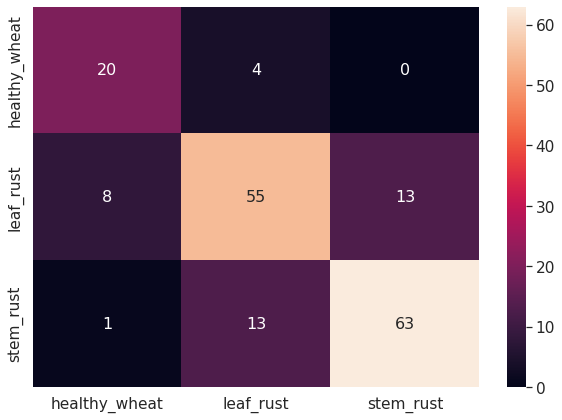

In [ ]:
# code here
accuracy = accuracy_score(true_label, class_label)
print('Accuracy for test data is:', accuracy)
con_m = confusion_matrix(true_label, class_label)
plot_confusion_matrix(con_m)


### Questions



What is overfitting? How are we trying to prevent overfitting here?

Answer: Overfitting happens when a model fits exactly against its training data. It learns noise and all other details in the training data, then it starts negatively effecting the performance of the model on unseen data. In overfitting, model fails to generalized.
Overfitting can be avoided in a model using different methods such as by early stopping, data augmentation, regularization, Dropouts method where Dropout is a regularization technique that prevents model from overfitting. Regularization methods like L1 and L2 reduce overfitting by modifying the cost function. Dropout on the other hand, modify the network itself. It randomly drops neurons from the neural network during training in each iteration, so different model will be learnt each time.

What is class imbalance? How does it effect training? Does this training set have class imbalance? If yes, then show it (using numbers).

Answer: Class imbalance occurs when one class contains significantly fewer no of training samples than other classs.
When there is class imbalance in the training dataset, the model tends to give poor predictive accuracy for the classes with fewer number of samples as compare to other classes.
 
This training dataset has class imbalance. It has less number of training samples for healthy_wheat class (which are 113). For the leaf_rust class, it has 286 training instances and for the stem_rust class, it has a 300 instances which more than twice the number of instances for the healthy_wheat class.


In [7]:
# code here
h_wheat = glob.glob('WheatDiseaseDataset/train/healthy_wheat/*.jpg')
leaf_rust = glob.glob('WheatDiseaseDataset/train/leaf_rust/*.jpg')
stem_rust = glob.glob('WheatDiseaseDataset/train/stem_rust/*.jpg')

print('No of samples belong to healthy_wheat class:', len(h_wheat))
print('No of samples belong to leaf_rust class:', len(leaf_rust))
print('No of samples belong to stem_rust class:', len(stem_rust))


No of samples belong to healthy_wheat class: 113
No of samples belong to leaf_rust class: 286
No of samples belong to stem_rust class: 300
